In [1]:
%cd /work/pi_wqd_umass_edu/pyxsim

/work/pi_wqd_umass_edu/pyxsim


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import matplotlib
import soxs
matplotlib.rc('font', size = 18)

soxs : [WARNING  ] 2024-07-23 14:39:47,979 Setting 'soxs_data_dir' to /home/dkidwell_umass_edu/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [3]:
import yt
import pyxsim
import re
import struct
import sys
import warnings
from io import open
import h5py
import astropy
from matplotlib.colors import LogNorm
from astropy.wcs import WCS
from astropy.io import fits
from scipy.ndimage import rotate
from astropy import wcs
import astropy.units as u
from pprint import pprint

In [25]:
from yt.units import Msun, pc, kyr
#loading data for athena++
Unit_Override = {"length_unit": (1.0, "pc"),
        "mass_unit": (1.0, "Msun"),
        "time_unit": (1.0, "kyr")}
ds = yt.load("torus_rst.out2.00350.athdf", units_override=Unit_Override, unit_system="cgs",
             magnetic_normalization="lorentz_heaviside",default_species_fields='ionized')

yt : [WARNING  ] 2024-07-23 14:58:53,281 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2024-07-23 14:58:53,282 Overriding length_unit: 1.0 pc.
yt : [INFO     ] 2024-07-23 14:58:53,288 Overriding time_unit: 1.0 kyr.
yt : [INFO     ] 2024-07-23 14:58:53,290 Overriding mass_unit: 1.0 Msun.
yt : [WARNING  ] 2024-07-23 14:58:53,292 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-07-23 14:58:53,388 Parameters: current_time              = 350.00012
yt : [INFO     ] 2024-07-23 14:58:53,389 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-07-23 14:58:53,390 Parameters: domain_left_edge          = [-5. -5. -5.]
yt : [INFO     ] 2024-07-23 14:58:53,391 Parameters: domain_right_edge         = [5. 5. 5.]
yt : [INFO     ] 2024-07-23 14:58:53,392 Parameters: cosmological_simulation   = 0


In [26]:
T_N = 10**4
def _neutral_h_density(field,data):
  nh = data['gas', 'H_nuclei_density']
  fac = np.zeros_like(nh.d)
  fac[data["gas","temperature"]< T_N] = 1.0
  return fac * nh

In [27]:
ds.add_field(("gas","H_p0_number_density"), _neutral_h_density, sampling_type="local", units="cm**-3")

In [28]:
dd = ds.all_data()

In [29]:
source_model = pyxsim.CIESourceModel("apec", 1.0, 2.0, 6000, Zmet = 3, kT_min = .025, kT_max = 20, max_density = 1.0e-18)

pyxsim : [INFO     ] 2024-07-23 14:58:55,802 kT_min = 0.025 keV
pyxsim : [INFO     ] 2024-07-23 14:58:55,806 kT_max = 20 keV


In [30]:
exp_time = (2000.0, "ks") #shorter exposure time because my computer has no memory.
area = (1500.0, "cm**2") 
redshift = 0 # its zero at first because it is local but I believe later I will be adding redshift.
dist = (8.18, "kpc")

In [31]:
inclination_angle = np.deg2rad(66)
position_angle = np.deg2rad(22)

In [32]:
# since the model is made on the Galactic plane we need to rotate it to an inclination of 66 deg and a position angle of 22 deg
from scipy.ndimage import rotate

inclination_angle = np.deg2rad(66)
position_angle = np.deg2rad(22)

#yflip2 = np.deg2rad(90)



# Define rotation matrix around z-axis (position angle)
Rtot = np.array([[np.cos(inclination_angle), np.sin(inclination_angle)*np.sin(position_angle), -np.sin(inclination_angle)*np.cos(position_angle)],
               [0, np.cos(position_angle), np.sin(position_angle)],
               [np.sin(inclination_angle), -np.cos(inclination_angle)*np.sin(position_angle), np.cos(inclination_angle)*np.cos(position_angle)]])




Rfin = np.linalg.inv(Rtot)
Thenormal_vector = Rfin[:,2]  #column
Thenorth_vector = Rfin[:,1]  #column
Theother_vector = Rfin[:,0]  
#Thenormal_vector1 = Rtest[:,2]  # Testing for other rotations
#Thenorth_vector1 = Rtest[:,1]  # Testing for other rotations



print("Rotation Matrix:")
print(Rfin)
#print(Rtest)
#print(Thenormal_vector1*-1)
#print(Thenorth_vector1*-1)
print("normal:")
print(Thenormal_vector)
print("North:")
print(Thenorth_vector)
print("---")
print ("Don't forget to mirror these values (change + and negative signs) because RA is increasing to the left and how the model is set up")
print("---")
print("Mirror Normal:")
print(Thenormal_vector*(-1))
print("Mirror North:")
print(Thenorth_vector*(-1))

print("The rotation above is not 100% accurate and we are currently still working on it so for now we are using the following vectors as our Normal and North")
print("The following vectors are from a very rough 90 degree rotation about the y-axis from the originals above")
print ("---")
L = [ 0.91354546, 0.15236623,  -0.37711965] # vector normal to cutting plane
north_vector = [ 3.74606593e-01,  -9.27183855e-01, 3.74606593e-01]
print("USE THIS NORMAL: <--")
print(L)
print("USE THIS NORTH: <--")
print(north_vector)


Rotation Matrix:
[[ 4.06736643e-01 -3.09322785e-17  9.13545458e-01]
 [ 3.42220152e-01  9.27183855e-01 -1.52366228e-01]
 [-8.47024599e-01  3.74606593e-01  3.77119649e-01]]
normal:
[ 0.91354546 -0.15236623  0.37711965]
North:
[-3.09322785e-17  9.27183855e-01  3.74606593e-01]
---
Don't forget to mirror these values (change + and negative signs) because RA is increasing to the left and how the model is set up
---
Mirror Normal:
[-0.91354546  0.15236623 -0.37711965]
Mirror North:
[ 3.09322785e-17 -9.27183855e-01 -3.74606593e-01]
The rotation above is not 100% accurate and we are currently still working on it so for now we are using the following vectors as our Normal and North
The following vectors are from a very rough 90 degree rotation about the y-axis from the originals above
---
USE THIS NORMAL: <--
[0.91354546, 0.15236623, -0.37711965]
USE THIS NORTH: <--
[0.374606593, -0.927183855, 0.374606593]


In [33]:
nwidth = (128)  # number of pixels in the width of the Athena map
ndepth = (128)  # number of pixels in the depth of the Athena map
width=(float(10.0), "pc") #width of simulation cube
depth = (float(10.0), "pc") #depth of simulation cube
c = ds.arr([0.0, 0.0, 0.0], "code_length") #setting the center


L = [ 9.1354546e-01, 1.5236623e-01,  -3.7711965e-01] # vector normal to cutting plane
N = [0.374606593, -0.927183855, 0.374606593] #the North (upward facing) vector

pyxsim.make_column_density_map(ds, L, c, width, depth, nwidth, ndepth, "internal_abs_REV.h5", north_vector=N,)

Determining a cube of neutral hydrogen column density :   0%|          | 0/128 [00:00<?, ?it/s]

In [48]:
ra0, dec0 = 266.42, -29 # center coords of image, from event file (updated to proper degrees)
nx = 255 # size of image, got from file (remember to update if you use a cut version)
#x=255 y=130 what is that in pixel space
dx = 0.5*u.arcsec # pixel size, you told me
twidth = (10)

In [36]:
with fits.open('smass-dist.fits') as hdu2:
    data2 = hdu2[0].data
    head2 = hdu2[0].header
    flux = data2*5.5e-9*(0.5**2) # applying the conversion so we have the file in flux
    filename = 'smass-dist.fits'
    output_filename = filename.split('/')[-1]
    fits.writeto('flux_'+ output_filename, flux, header=head2, overwrite=True)

In [37]:
f = "flux_smass-dist.fits"

fd = fits.getdata(f)
head = fits.getheader(f)


"""    #remove left side
fd1 = np.delete(fd, slice(0,150), 1)
    #remove right side (remember the right limit has already been reduced)
fd2 = np.delete(fd1,slice(312,462),1)
    #remove bottom
fd3 = np.delete(fd2,slice(0,150),0)
    #remove top(remember the top limit has already been reduced)
fd_done = np.delete(fd3,slice(312,462),0) """
fits.writeto("flux_NCcut.fits",fd, header= head, overwrite=True)
print("finished")

finished


In [38]:
w=WCS(naxis=2)
w.wcs.cunit = ["deg"]*2
w.wcs.crval = [ra0, dec0] # center of image in RA, Dec
w.wcs.crpix = [(nx+1),.5*(nx+1)] # center of image in pixel space
w.wcs.cdelt = [-dx.to_value("deg"), dx.to_value("deg")]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wheader = w.to_header()
pprint(wheader)

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                256.0 / Pixel coordinate of reference point            
CRPIX2  =                128.0 / Pixel coordinate of reference point            
CDELT1  = -0.00013888888888889 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00013888888888889 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =               266.42 / [deg] Coordinate value at reference point      
CRVAL2  =                -29.0 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =                -29

In [39]:
with fits.open("flux_NCcut.fits") as f:
    data = f[0].data.copy()
    tot_flux = data.sum()
    header = f[0].header.copy()
    header.update(wheader)
    hdu = fits.PrimaryHDU(data, header=header)
    hdu.writeto("flux_NCcut_sky.fits", overwrite=True)

In [40]:
agen = soxs.ApecGenerator(3.0, 9.0, 1000) #Changing this (to fewer bins or a smaller range (so far 3-10 has worked, will greatly reduce the photons generated 
spec = agen.get_spectrum(0.8, 1.0, 0.0, 1.0) # I normalized this to 1 at first (kT, abund, redshift, norm)
spec.rescale_flux(tot_flux, emin=4, emax=9) # now rescale by the flux from the file
spec.apply_foreground_absorption(11, model="tbabs") # n_H is The hydrogen column in units of 10**22 atoms/cm**2 we set 11


In [41]:
bkg_src = soxs.SimputSpectrum.from_spectrum("NSCcut", spec, ra0, dec0, imhdu="flux_NCcut_sky.fits")

In [42]:
sim_cat = soxs.SimputCatalog.from_source(
    "NSCcut_simput.fits", bkg_src, overwrite=True
)

soxs : [INFO     ] 2024-07-23 15:12:44,172 Appending source 'NSCcut' to NSCcut_simput.fits.


In [43]:
soxs.instrument_simulator("NSCcut_simput.fits", "NSC13cut_230ks_evt.fits", (230, "ks"),
                          "chandra_aciss_cy22", [266.42, -29], instr_bkgnd=False,
                          foreground=False, ptsrc_bkgnd=False, overwrite=True)

soxs : [INFO     ] 2024-07-23 15:12:44,870 Making observation of source in NSC13cut_230ks_evt.fits.
soxs : [INFO     ] 2024-07-23 15:12:45,015 Detecting events from source NSCcut.
soxs : [INFO     ] 2024-07-23 15:12:45,017 Applying energy-dependent effective area from aciss_aimpt_cy22.arf.
soxs : [INFO     ] 2024-07-23 15:13:07,946 Pixeling events.
soxs : [INFO     ] 2024-07-23 15:13:26,634 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-07-23 15:13:50,118 44478375 events were detected from the source.
soxs : [INFO     ] 2024-07-23 15:13:54,313 Scattering energies with RMF aciss_aimpt_cy22.rmf.


Scattering energies :   0%|          | 0/44478375 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-07-23 15:14:09,306 No backgrounds will be added to this observation.
soxs : [INFO     ] 2024-07-23 15:14:09,308 Writing events to file NSC13cut_230ks_evt.fits.
soxs : [INFO     ] 2024-07-23 15:14:22,494 Observation complete.


In [44]:
soxs.write_image("NSC13cut_230ks_evt.fits", "NSC13cut_230ks_img.fits", overwrite=True)

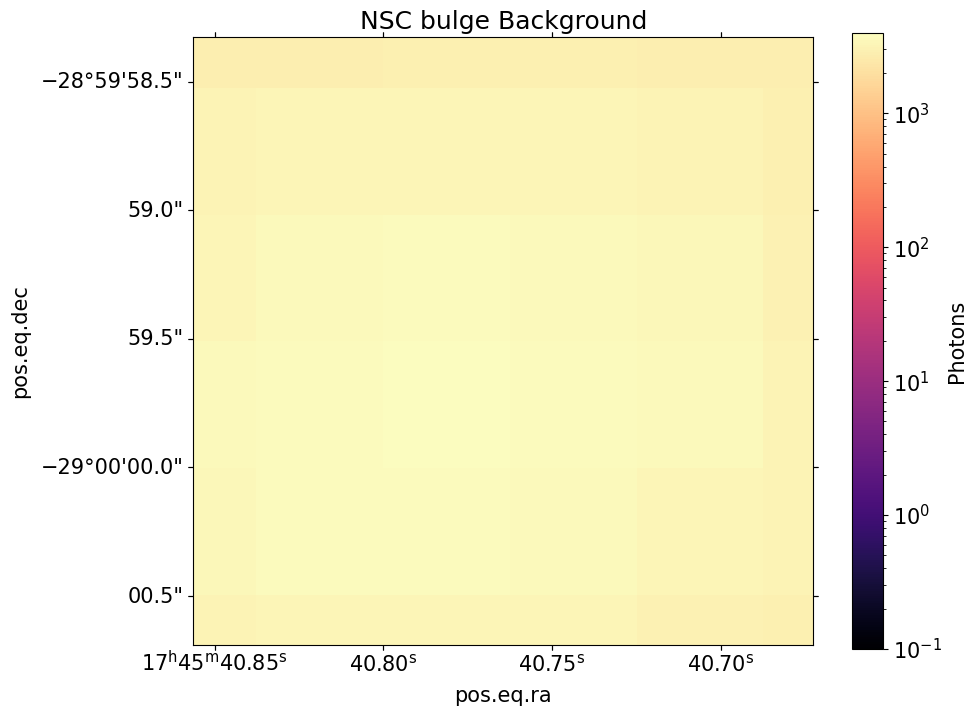

In [49]:
with fits.open("NSC13cut_230ks_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*twidth, center[0]+0.24*twidth) 
    ax.set_ylim(center[1]-0.24*twidth, center[1]+0.24*twidth)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("NSC bulge Background")
    fig.colorbar(p,label = 'Photons',shrink=0.80)

In [50]:
soxs.merge_event_files(["REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits", "NSC13cut_230ks_evt.fits"], "totchandra_230kscut_evt.fits", overwrite=True)

ValueError: 'INSTRUME' from NSC13cut_230ks_evt.fits does not match from REVabs_MHD_dp15m2Ms_lynx230ks_evt.fits! chandra_aciss_cy22 != chandra_acisi_cy22!

In [ ]:
soxs.write_image("totchandra_230kscut_evt.fits", "totchandra_230kscut_img.fits", overwrite=True)

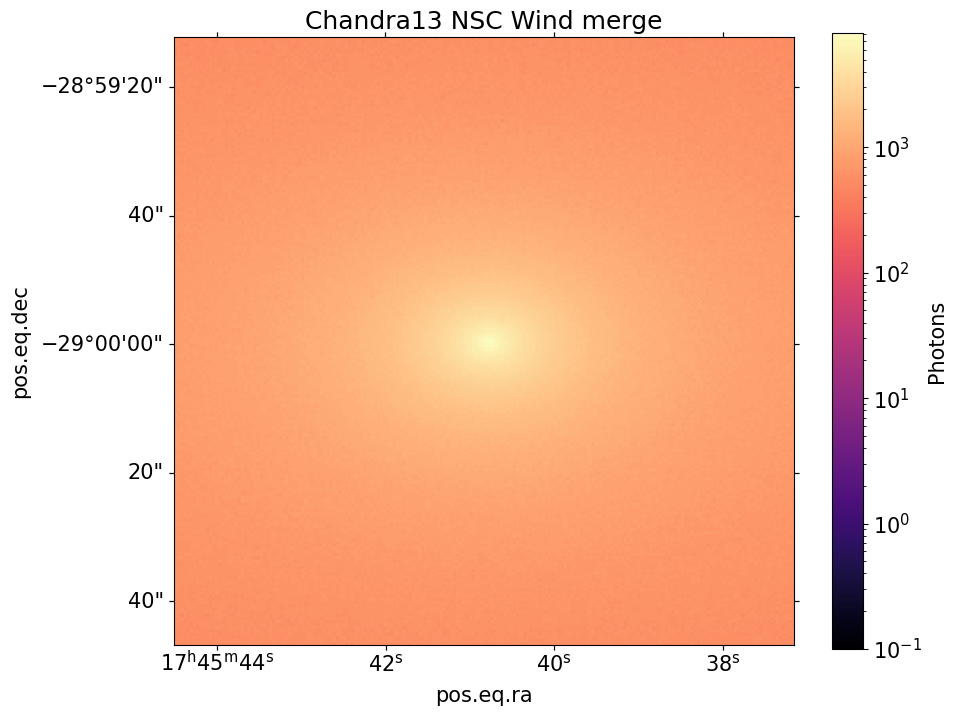

In [51]:
from astropy.io import fits
width = 400
with fits.open("totchandra_230kscut_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("Chandra13 NSC Wind merge")

    fig.colorbar(p,label = 'Photons',shrink=0.80)